In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, true=None, false=None,*,value=None):
        '''
        Class to represent a leaf or a decision node in the decision tree.
        Parameters:
        -----------
        feature: int, default: None
            Feature index that we use to measure the best threshold to get the maximum information gain and decide
            other samples whether it's true (less than or equal with threshold) or false (more than threshold).
        threshold: float, default: None
            The value that used to compare to another samples at the same feature index to determine the decision.
        true: Node, default: None
            Next decision node for the samples where the feature value less than or equal with threshold.
        false: Node, default: None
            Next decision node for the samples where the feature value more than threshold.
        value: float, default: None
            Class prediciton if decision tree, or a float if regression tree.
        '''
        self.feature = feature
        self.threshold = threshold
        self.true = true
        self.false = false
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [3]:
class DecisionTree:
    '''
    Class too build the decision tree from given data.
    Parameters:
    -----------
    min_samples_split: int, default: 2
        The minimum number of samples to split when building the tree.
    max_depth: int, default: 100
        The maximum depth of the tree.
    n_features: int, deafult: None
        The number of features that the data has.
    '''
    
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def build_tree(self, X, y, depth=0):
        
        ''' 
        A recursive method to build the decision tree by split the data samples with respect to the label on the 
        feature of data and decide the best separates based on impurity.
        '''

        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # If these stopping criterias are satisfied, then it's a leaf
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self.calculate_leaf_value(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_split = self._best_split(X, y, feat_idxs)

        # create child nodes
        true_idxs, false_idxs = self._split(X[:, best_split['best_feature']], best_split['best_threshold'])
        true = self.build_tree(X[true_idxs, :], y[true_idxs], depth+1)
        false = self.build_tree(X[false_idxs, :], y[false_idxs], depth+1)
        return Node(best_split['best_feature'], best_split['best_threshold'], true, false)

    def _best_split(self, X, y, feat_idxs):
        
        '''
        A function to determine the best split based on feature index, best threshold of the feature and the maximum
        information gain.
        '''
        
        #Dictionary to store the best split data
        best_split = {}
        
        best_gain = -1

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    best_split['best_feature'] = feat_idx
                    best_split['best_threshold'] = thr
                    best_split['best_gain'] = gain

        return best_split

    def _information_gain(self, y, X_column, threshold):
        
        '''
        A function to get the information gain of the feature index using the gini index of the data.
        '''
        
        # parent gini index
        parent_gini = self.gini_index(y)

        # create children
        true_idxs, false_idxs = self._split(X_column, threshold)

        if len(true_idxs) == 0 or len(false_idxs) == 0:
            return 0
        
        # calculate the weighted avg. gini index of children
        n = len(y)
        n_t, n_f = len(true_idxs), len(false_idxs)
        g_t, g_f = self.gini_index(y[true_idxs]), self.gini_index(y[false_idxs])
        child_gini = (n_t/n) * g_t + (n_f/n) * g_f

        # calculate the IG
        information_gain = parent_gini - child_gini
        return information_gain
    
    def gini_index(self, y):
        
        '''
        A function to calculate the gini index.
        '''
        
        labels = np.unique(y)
        gini = 0
        
        for label in labels:
            point = len(y[y==label])/len(y)
            gini += point**2
        return 1-gini

    def _split(self, X_column, split_thresh):
        
        '''
        A function to split indexes where the given data is less than or more than threshold.
        '''
        
        true_idxs = np.argwhere(X_column <= split_thresh).flatten()
        false_idxs = np.argwhere(X_column > split_thresh).flatten()
        return true_idxs, false_idxs

    def calculate_leaf_value(self, y):
        
        '''
        A function to calculate the leaf value 
        '''
        
        y = list(y)
        return max(y, key=y.count)

    def fit(self, X, y):
        
        '''
        Bulid the decision tree from given data.
        '''
        
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self.build_tree(X, y)

    def predict(self, X):
        
        '''
        Classify samples one by one to get a set of labels.
        '''
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def traverse_tree(self, x, node):
       
        '''
        Do a recursive search down the tree and make a prediction the label of the data sampe by the value of the 
        leaf that we end up at.
        '''
        
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.true)
        return self.traverse_tree(x, node.false)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature), "<=", tree.threshold, "?")
            print("%strue:" % (indent), end="")
            self.print_tree(tree.true, indent + indent)
            print("%sfalse:" % (indent), end="")
            self.print_tree(tree.false, indent + indent)

In [4]:
def train_test_split(X, y, test_size=0.3, random_state=None, shuffle=True):
    ''' 
    Split the datasets into train data and test data.
    '''
    if shuffle:
        X, y = shuffleData(X, y, random_state)
  
    split_idx = int(len(y) - (len(y) // (1/test_size)))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X_train, X_test, y_train, y_test
  
def shuffleData(X, y, random_state=None):
    '''
    Random shuffle data from the given samples.
    '''
    if random_state:
        np.random.seed(random_state)
    idxs = np.arange(X.shape[0])
    np.random.shuffle(idxs)

    return X.to_numpy()[idxs], y.to_numpy()[idxs]

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

def cross_val_score(model, X, y, scoring='accuracy', *, cv):
    
    scores = []

    for train_idx, test_idx in cv.split(X):
        X_train_val, X_test_val = X.to_numpy()[train_idx], X.to_numpy()[test_idx]
        y_train_val, y_test_val = y.to_numpy()[train_idx], y.to_numpy()[test_idx]
        model.fit(X_train_val, y_train_val)
        pred = model.predict(X_test_val)
        scores.append(accuracy_score(y_test_val, pred))
    return scores

In [5]:
flights_data = pd.read_csv('flights.csv')
low_memory = False

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
flights_data

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,...,753.0,-26.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819075,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,...,430.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819076,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,...,432.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819077,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,...,330.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 0 = On time/ before time/ not more than 15 mins of delay
# 1 = more than 15 mins and less than 30 mins of delay
# 2 = more than 30 mins and less than 1 hr of delay
# 3 = more than an hour of delay

Flight_data_delay =[]
for row in flights_data['ARRIVAL_DELAY']:
    if row > 60:
        Flight_data_delay.append(3)
    elif row > 30:
        Flight_data_delay.append(2)
    elif row > 15:
        Flight_data_delay.append(1)
    else:
        Flight_data_delay.append(0)  
flights_data['Delay'] = Flight_data_delay

In [8]:
flights_data.corr()[['Delay']].sort_values(by='Delay',ascending=False)

,Delay
Delay,1.000000
ARRIVAL_DELAY,0.798470
DEPARTURE_DELAY,0.742336
LATE_AIRCRAFT_DELAY,0.431899
AIRLINE_DELAY,0.289193
TAXI_OUT,0.241133
AIR_SYSTEM_DELAY,0.204263
DEPARTURE_TIME,0.189472
WHEELS_OFF,0.187243
WEATHER_DELAY,0.139379


In [9]:
flights_data=flights_data.drop(['YEAR','FLIGHT_NUMBER','AIRLINE','DISTANCE','TAIL_NUMBER','TAXI_OUT','SCHEDULED_TIME','DEPARTURE_TIME','WHEELS_OFF','ELAPSED_TIME','AIR_TIME','WHEELS_ON','DAY_OF_WEEK','TAXI_IN','CANCELLATION_REASON','ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', "CANCELLED"],
                                             axis=1)

In [10]:
flights_data.isna().sum()

MONTH                        0
DAY                          0
SCHEDULED_DEPARTURE          0
DEPARTURE_DELAY          86153
SCHEDULED_ARRIVAL            0
DIVERTED                     0
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
Delay                        0
dtype: int64

In [11]:
flights_data=flights_data.fillna(flights_data.mean())

In [12]:
flights_data.isna().sum()

MONTH                  0
DAY                    0
SCHEDULED_DEPARTURE    0
DEPARTURE_DELAY        0
SCHEDULED_ARRIVAL      0
DIVERTED               0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
Delay                  0
dtype: int64

In [13]:
flights_data.corr()[['Delay']].sort_values(by='Delay',ascending=False)

,Delay
Delay,1.000000
DEPARTURE_DELAY,0.741363
LATE_AIRCRAFT_DELAY,0.202795
AIRLINE_DELAY,0.135789
SCHEDULED_DEPARTURE,0.131370
SCHEDULED_ARRIVAL,0.114775
AIR_SYSTEM_DELAY,0.095910
WEATHER_DELAY,0.065445
SECURITY_DELAY,0.005287
DAY,-0.006595


<AxesSubplot:>

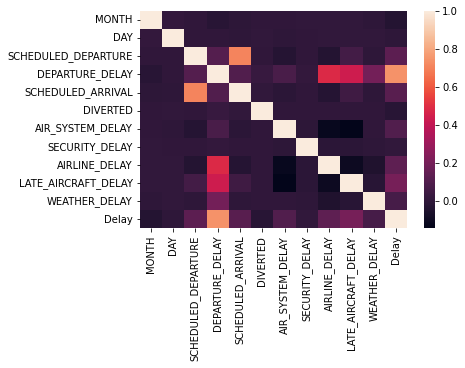

In [14]:
import seaborn as sns
sns.heatmap(flights_data.corr())

In [15]:
flights_data.value_counts('Delay')

Delay
0    4795581
1     390801
3     319092
2     313605
dtype: int64

In [16]:
flights_random_sampling = flights_data.groupby('Delay').apply(lambda x: x.sample(frac=0.001 if x.Delay.iloc[0]=='0' else 0.01))

In [17]:
flights_random_sampling.shape

(58191, 12)

In [18]:
X = flights_random_sampling.drop(columns=['Delay'])
y = flights_random_sampling['Delay']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
classifier = DecisionTree(max_depth=10)
classifier.fit(X_train, y_train)

In [21]:
y_pred = classifier.predict(X_test)

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14417
           1       0.89      0.90      0.90      1145
           2       0.87      0.88      0.87       935
           3       0.96      0.96      0.96       960

    accuracy                           0.98     17457
   macro avg       0.93      0.93      0.93     17457
weighted avg       0.98      0.98      0.98     17457



# Validation Test

In [23]:
cv = KFold(n_splits=5, random_state = 42, shuffle = True)
scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv)

In [24]:
scores

[0.9809261964086262,
 0.9832445437360371,
 0.9814401099845335,
 0.9841037979034198,
 0.9816978862347482]

In [25]:
print(f"K-Fold Cross Validation Mean Scores: {np.mean(scores)}")

K-Fold Cross Validation Mean Scores: 0.982282506853473
